<a href="https://colab.research.google.com/github/MathewNhari/CV/blob/master/Final_Sendy_Challenge_Still%20need%20cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor

#**Importing Data**

In [2]:
riders = pd.read_csv('Riders.csv')
sample = pd.read_csv('SampleSubmission.csv')
test = pd.read_csv('Test.csv')
train = pd.read_csv('Train.csv', parse_dates= ['Placement - Day of Month'])
vd = pd.read_csv('VariableDefinitions.csv')

**Sample Submission**

In [3]:
sample.head()

,Order_No,Time from Pickup to Arrival
0,Order_No_19248,567.0
1,Order_No_12736,4903.0
2,Order_No_768,5649.0
3,Order_No_15332,NaN
4,Order_No_21373,NaN


In [4]:
riders.head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


In [5]:
train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  object 
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [7]:
#getting the same columns in train as in test data
train_cols = list(train.columns)
test_cols = list(test.columns)
cols = [col for col in train_cols if col in test_cols]
cols.append('Time from Pickup to Arrival')
train =  train[cols]

In [8]:
train.head(1)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,4,20.4,NaN,-1.317755,36.83037,-1.300406,36.829741,Rider_Id_432,745


# Joining Tables

In [9]:
train = train.merge(riders,on='Rider Id',how='left')
test = test.merge(riders,on='Rider Id',how='left')

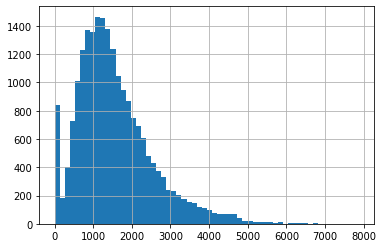

In [10]:
train['Time from Pickup to Arrival'].hist(bins=60)

# **Data Cleaning**

In [11]:
def data_clean(df):
  time_cols = ['Placement - Time','Confirmation - Time','Arrival at Pickup - Time','Pickup - Time']
  
  cat_cols = ['Platform Type','Personal or Business', 'Placement - Weekday (Mo = 1)',
        'Confirmation - Weekday (Mo = 1)','Pickup - Weekday (Mo = 1)','Vehicle Type']
  
  df['Placement - Day of Month'] = df['Placement - Day of Month'].astype('int')
  
  for time in time_cols:
    df[time] = df[time].astype('datetime64')
    df[time+'_hour'] = pd.to_datetime(df[time]).dt.hour
    df[time+'_minutes'] = pd.to_datetime(df[time]).dt.minute
    df[time+'_seconds'] = pd.to_datetime(df[time]).dt.second
  df.drop(time_cols,axis=1, inplace = True)
  
  #get dummy variables
  df = pd.get_dummies(df,columns= cat_cols,drop_first = True)
  cols = ['Precipitation in millimeters','User Id','Rider Id']
  df.drop(cols,axis=1, inplace = True)

  #impute missing data
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
  imputer.fit(np.array(df['Temperature']).reshape(-1,1))
  df['Temperature'] = imputer.transform(np.array(df['Temperature']).reshape(-1,1))
  return df
train = data_clean(train)
test = data_clean(test)

# **Feature Engineering**

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 51 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              21201 non-null  object 
 1   Placement - Day of Month              21201 non-null  int64  
 2   Confirmation - Day of Month           21201 non-null  int64  
 3   Arrival at Pickup - Day of Month      21201 non-null  int64  
 4   Arrival at Pickup - Weekday (Mo = 1)  21201 non-null  int64  
 5   Pickup - Day of Month                 21201 non-null  int64  
 6   Distance (KM)                         21201 non-null  int64  
 7   Temperature                           21201 non-null  float64
 8   Pickup Lat                            21201 non-null  float64
 9   Pickup Long                           21201 non-null  float64
 10  Destination Lat                       21201 non-null  float64
 11  Destination Lon

**Variable Selection by Correlation and Significance**

In [13]:
# Calculate correlations between predictor variables and the response variable
corrs = train.corr()['Time from Pickup to Arrival'].sort_values(ascending=False)

In [14]:
corrs

Time from Pickup to Arrival             1.000000
Distance (KM)                           0.580608
Destination Long                        0.070425
Pickup Long                             0.060285
Pickup - Weekday (Mo = 1)_5             0.018667
Confirmation - Weekday (Mo = 1)_5       0.018667
Placement - Weekday (Mo = 1)_5          0.018667
Arrival at Pickup - Time_hour           0.017129
Pickup - Weekday (Mo = 1)_2             0.016140
Confirmation - Weekday (Mo = 1)_2       0.016140
Placement - Weekday (Mo = 1)_2          0.016044
Personal or Business_Personal           0.013354
Pickup - Time_minutes                   0.012259
Pickup - Weekday (Mo = 1)_7             0.012018
Placement - Weekday (Mo = 1)_7          0.012018
Confirmation - Weekday (Mo = 1)_7       0.012018
Pickup - Time_hour                      0.010314
Arrival at Pickup - Time_minutes        0.010009
Arrival at Pickup - Weekday (Mo = 1)    0.009744
Confirmation - Weekday (Mo = 1)_3       0.007819
Pickup - Weekday (Mo

In [15]:
X = train.drop('Time from Pickup to Arrival',axis=1)
feature_corrs = X.corr()

In [16]:
# find rows and columns where correlation coefficients > 0.9 or <-0.9
rows, cols = np.where(np.abs(feature_corrs) > 0.9)

# We are only interested in the off diagonal entries:
off_diagonal = np.where(rows != cols)

# Show the correlation matrix rows and columns where we have highly correlated off diagonal entries:
corr = feature_corrs.iloc[rows[off_diagonal], cols[off_diagonal]]

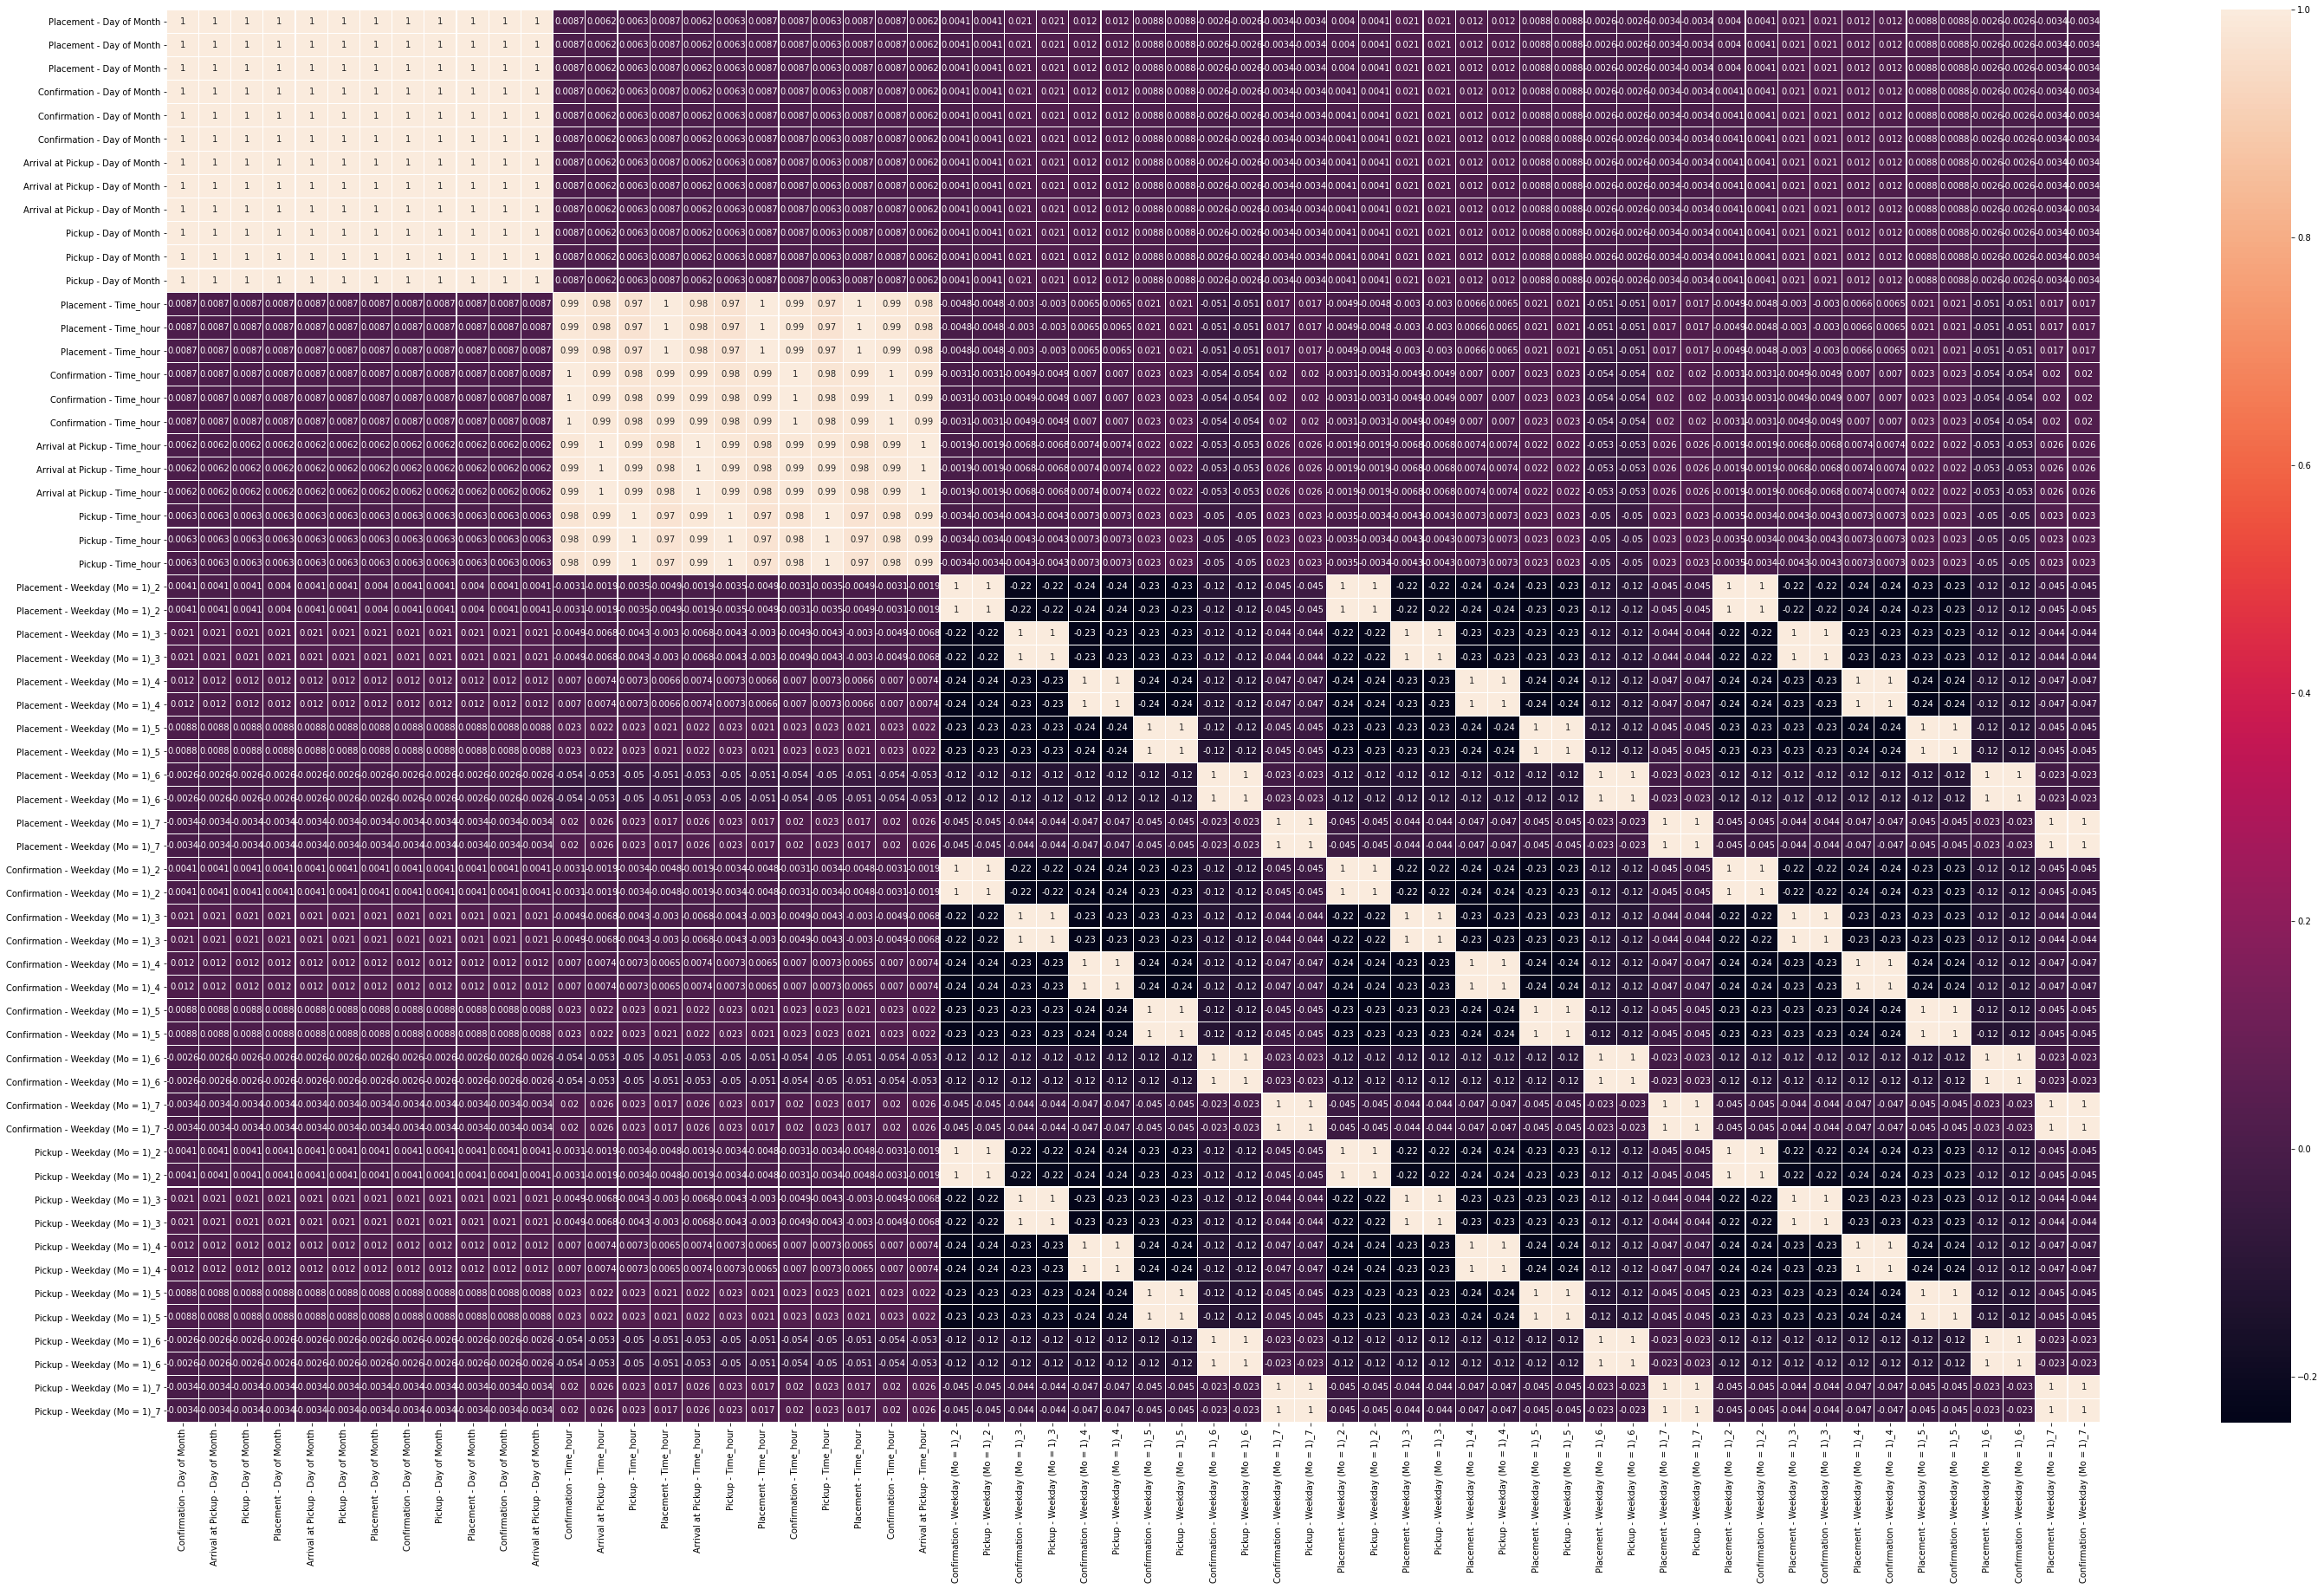

In [17]:
plt.subplots(figsize=(50,30))
sns.heatmap(corr,linewidths=0.1,annot=True)

In [18]:
correlated_features = []
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.append(colname)

In [19]:
X = X.drop(correlated_features,axis=1)
X_test = test[X.columns]
y = train['Time from Pickup to Arrival']

# Building Models


In [20]:
#dropping the Order_No column
X = X.drop('Order No',axis=1)
X_test = X_test.drop('Order No',axis=1)

**Feature Scaling**

In [21]:
# create standardization object
scaler_X = StandardScaler()
#scaler_y = StandardScaler()

**splitting features into test set and training set**

In [22]:
X_scaled = scaler_X.fit_transform(X)
#y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))

In [23]:
#split dataset into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=1)

**Ridge Model**

In [24]:
ridge = Ridge()
regressor = LinearRegression()

In [25]:
ridge.fit(X_train, y_train)
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
ridge_pred = ridge.predict(X_val)
regressor_pred = regressor.predict(X_val)

In [27]:
ridge_rmse = mean_squared_error(y_val, ridge_pred, squared= False)
regressor_rmse = mean_squared_error(y_val, regressor_pred, squared= False)

In [28]:
ridge_rmse

789.8458688439575

In [29]:
regressor_rmse

789.8464714843503

Building Decision Tree

In [30]:
reg_tree = DecisionTreeRegressor(max_depth=3)

In [31]:
reg_tree.fit(X_train,y_train)
dt_pred = reg_tree.predict(X_val)

In [32]:
dt_rmse = mean_squared_error(y_val, dt_pred, squared= False)

In [33]:
dt_rmse

793.4983953114167

SVR Model

In [34]:
sv_reg = SVR(kernel='rbf', gamma='auto')
sv_reg.fit(X_train,y_train)
svr_pred = sv_reg.predict(X_val)

In [35]:
svr_rmse = mean_squared_error(y_val, svr_pred, squared= False)

In [36]:
svr_rmse

928.8334909376274

Lasso Model

In [37]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)

In [38]:
lasso_rmse = mean_squared_error(y_val, y_pred, squared= False)
lasso_rmse

789.8442004439142

XGBoost model

In [39]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

[10:03:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [40]:
xgb_pred = xgb.predict(X_val)

In [41]:
xgb_rmse = mean_squared_error(y_val, y_pred, squared= False)

In [42]:
xgb_rmse

789.8442004439142

Stacking method

In [43]:
models = [("DT",reg_tree),("Ridge",ridge),("lasso",lasso),("xgb",xgb),("regressor",regressor),("svr",sv_reg)]

In [44]:
meta_learner_reg = LinearRegression()
s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)

In [45]:
s_reg.fit(X_train,y_train)

[10:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=None,
                  estimators=[('DT',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=3,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
                                                   

In [46]:
s_reg_pred = s_reg.predict(X_val)

In [47]:
meta_rmse = mean_squared_error(y_val, s_reg_pred, squared= False)

In [48]:
meta_rmse

755.7258398578352

Submission

In [49]:
#Test_data['Arrival at Destination - Day of Month','Arrival at Destination - Weekday (Mo = 1)',
#             'Arrival at Destination - Time']==np.nan

In [50]:
X_test =scaler_X.transform(X_test)

In [51]:
submit_test = s_reg.predict(X_test)

In [52]:
output = pd.DataFrame(submit_test,columns=['Time from Pickup to Arrival'])

In [53]:
output

,Time from Pickup to Arrival
0,1375.211568
1,1363.456678
2,1389.072384
3,1221.128844
4,1193.123849
...,...
7063,1547.846784
7064,2494.528034
7065,1755.238351
7066,2560.859609


In [54]:
test.reset_index(level=0, inplace=True)

In [55]:
dataset = pd.concat(objs=[test, output], axis=1)

In [56]:
dataset.head(3)

,index,Order No,Placement - Day of Month,Confirmation - Day of Month,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement - Time_hour,Placement - Time_minutes,Placement - Time_seconds,Confirmation - Time_hour,Confirmation - Time_minutes,Confirmation - Time_seconds,Arrival at Pickup - Time_hour,Arrival at Pickup - Time_minutes,Arrival at Pickup - Time_seconds,Pickup - Time_hour,Pickup - Time_minutes,Pickup - Time_seconds,Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Placement - Weekday (Mo = 1)_2,Placement - Weekday (Mo = 1)_3,Placement - Weekday (Mo = 1)_4,Placement - Weekday (Mo = 1)_5,Placement - Weekday (Mo = 1)_6,Placement - Weekday (Mo = 1)_7,Confirmation - Weekday (Mo = 1)_2,Confirmation - Weekday (Mo = 1)_3,Confirmation - Weekday (Mo = 1)_4,Confirmation - Weekday (Mo = 1)_5,Confirmation - Weekday (Mo = 1)_6,Confirmation - Weekday (Mo = 1)_7,Pickup - Weekday (Mo = 1)_2,Pickup - Weekday (Mo = 1)_3,Pickup - Weekday (Mo = 1)_4,Pickup - Weekday (Mo = 1)_5,Pickup - Weekday (Mo = 1)_6,Pickup - Weekday (Mo = 1)_7,Time from Pickup to Arrival
0,0,Order_No_19248,27,27,27,3,27,8,23.24612,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171,16,44,10,16,44,29,16,53,4,17,6,47,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1375.211568
1,1,Order_No_12736,17,17,17,5,17,5,23.24612,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45,12,57,35,12,59,17,13,20,27,13,25,37,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1363.456678
2,2,Order_No_768,27,27,27,4,27,5,22.80000,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67,11,8,14,11,25,5,11,33,20,11,57,54,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1389.072384


In [57]:
submit_DataFrame = dataset[['Order No','Time from Pickup to Arrival']]

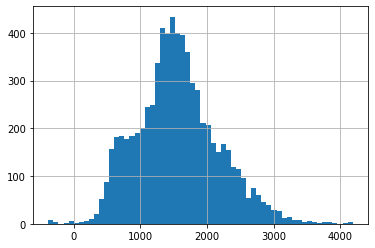

In [58]:
submit_DataFrame['Time from Pickup to Arrival'].hist(bins=60)

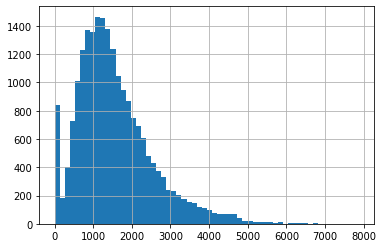

In [59]:
train['Time from Pickup to Arrival'].hist(bins=60)

In [60]:
submit_DataFrame.to_csv('Zindi_Regression_submission.csv', index=False)

In [61]:
from google.colab import files
files.download('Zindi_Regression_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>